In [4]:
data_dir = 'C:\\Users\\chris\\Documents\\GitHub\\data\\f28e28af-5e8b-44e4-bf01-e85eb1c221fb\\f28e28af-5e8b-44e4-bf01-e85eb1c221fb\\load'

In [5]:
file1 = '68907590-9b66-477d-9112-36e16be09c24.csv'
file2 = '94466047-4726-4b92-8dcc-2e69aa16debf.csv'

In [6]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
print(onlyfiles[0])

0016d991-8fc4-4a43-9d27-d50304b03791.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
rnd = np.random.randint(0,len(onlyfiles),2)
pd1 = pd.read_csv(join(data_dir,onlyfiles[rnd[0]]),sep=';',parse_dates=[0],date_parser=lambda col: pd.to_datetime(col, utc=True))
pd2 = pd.read_csv(join(data_dir,onlyfiles[rnd[1]]),sep=';',parse_dates=[0],date_parser=lambda col: pd.to_datetime(col, utc=True))

In [9]:
pd1.dtypes

date_tz    datetime64[ns, UTC]
kWh/h                  float64
dtype: object

In [10]:
pd1.head(4)

date_tz  kWh/h
0 2018-01-22 00:00:00+00:00   4.03
1 2018-01-22 01:00:00+00:00   3.81
2 2018-01-22 02:00:00+00:00   4.14
3 2018-01-22 03:00:00+00:00   4.21

In [11]:
pd1=pd1.set_index('date_tz')
pd2=pd2.set_index('date_tz')
pd1 = pd1[~pd1.index.duplicated()]
pd2 = pd2[~pd2.index.duplicated()]

In [12]:
m1 = pd1['kWh/h'].mean()
m2 = pd2['kWh/h'].mean()
pd1['kWh/h'] = pd1['kWh/h']-m1
pd2['kWh/h'] = pd2['kWh/h']-m2

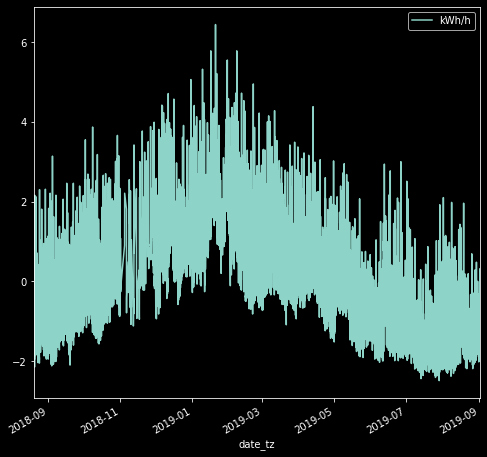

In [13]:
pd1.plot(figsize=[8,8])
pd2.plot(figsize=[8,8])

In [14]:
pd1_rs = pd1.resample(rule='W',axis=0).mean()
pd2_rs = pd2.resample(rule='W',axis=0).mean()

C:\Users\chris\.conda\envs\EV_DETECTION\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


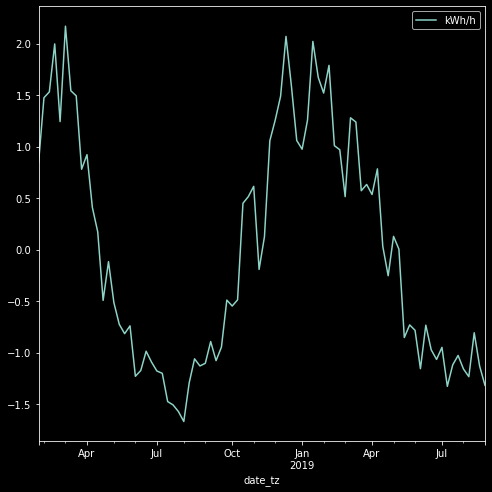

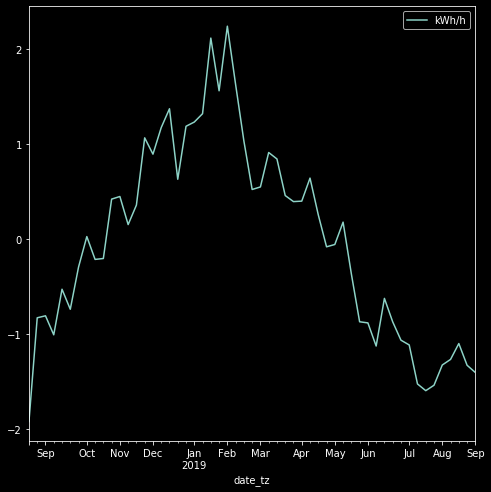

In [15]:
pd1_rs.plot(figsize=[8,8])
pd2_rs.plot(figsize=[8,8])

## TSLEARN Sandbox

In [16]:
from tslearn.utils import to_time_series_dataset,to_time_series

In [17]:
ts1 = to_time_series(pd1['kWh/h'])
ts2 = to_time_series(pd2['kWh/h'])

In [ ]:
#from tslearn.metrics import dtw

In [ ]:
#ff = dtw(ts1,ts2)

In [ ]:
#ff

## trying to fit seasonal trend

In [18]:
from PyEMD import EMD,Visualisation
emd1 = EMD()
emd2 = EMD()

In [19]:
emd1.FIXE = 10
imfs1 = emd1(pd1_rs['kWh/h'])
emd2.FIXE = 10
imfs2 = emd2(pd2_rs['kWh/h'])

C:\Users\chris\.conda\envs\EV_DETECTION\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


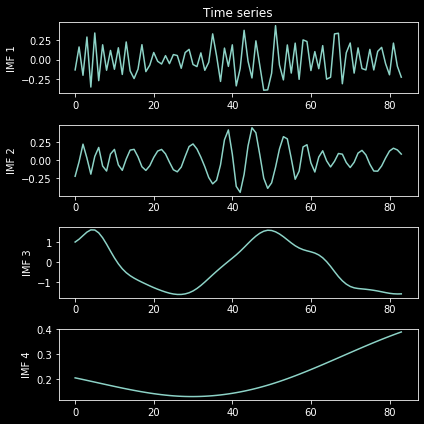

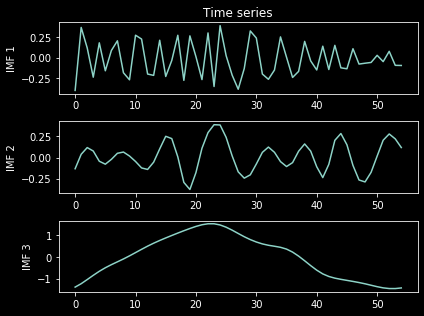

In [20]:
v1=Visualisation()
v1.plot_imfs(imfs=imfs1,include_residue=False)
v2=Visualisation()
v2.plot_imfs(imfs=imfs2,include_residue=False)

## Identify the correct IMF to remove
Important to have an automatic way to select the IMFs to remove

In [39]:
print(imfs1.shape)
print(imfs2.shape)

(4, 84)
(3, 55)


In [45]:
np.amax(imfs1,axis=1)-np.amin(imfs1,axis=1)
np.amax(imfs2,axis=1)-np.amin(imfs2,axis=1)

array([0.78393194, 0.76900621, 2.97361063])

In [49]:
def select_imfs(imfs):
    #
    shape_input = imfs.shape
    idx_start = shape_input[0]-1
    detrending_imf = np.zeros((1,shape_input[-1]),dtype=float)
    #
    interval = np.amax(imfs,axis=1)-np.amin(imfs,axis=1)
    for idx_start in range(shape_input[0]-1,0,-1):
        detrending_imf+=imfs[idx_start,:]
        if interval[idx_start]==max(interval):
            break
    return detrending_imf
        

(1, 84)


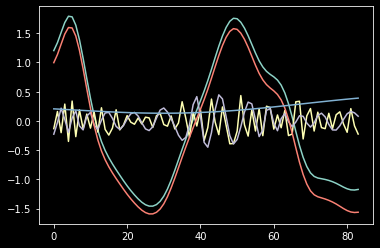

In [54]:
imfs3=select_imfs(imfs1)
plt.plot(imfs3.transpose())
plt.plot(imfs1.transpose())

In [79]:
imfs1_pd=pd.DataFrame.from_records(np.transpose(select_imfs(imfs1)),index=pd1_rs.index,columns=['imf'])
imfs2_pd=pd.DataFrame.from_records(np.transpose(select_imfs(imfs2)),index=pd2_rs.index,columns=['imf'])
#imfs1_pd=pd.DataFrame.from_records(np.transpose(imfs1),index=pd1_rs.index,columns=[f'imf{n}' for n in range(0,imfs1.shape[0])])
#imfs2_pd=pd.DataFrame.from_records(np.transpose(imfs2),index=pd2_rs.index,columns=[f'imf{n}' for n in range(0,imfs2.shape[0])])

(1, 81)
(1, 136)


In [80]:
pd1_new = pd1_rs.merge(right=imfs1_pd,left_index=True,right_index=True)
pd2_new = pd2_rs.merge(right=imfs2_pd,left_index=True,right_index=True)

C:\Users\chris\.conda\envs\EV_DETECTION\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



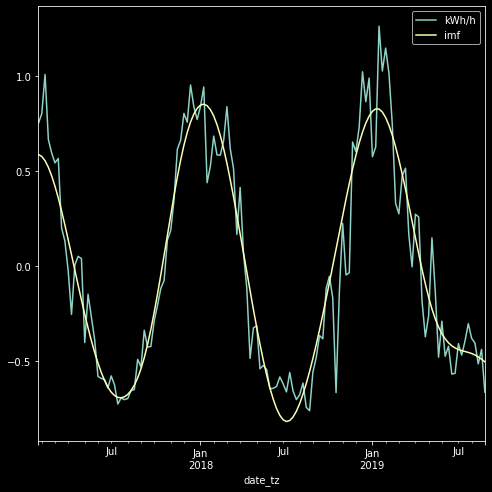

In [81]:
pd1_new.plot(figsize=[8,8])
pd2_new.plot(figsize=[8,8])

In [82]:
imfs1_pd_hr = imfs1_pd.resample(rule='H',axis=0).interpolate(method='linear')
imfs2_pd_hr = imfs2_pd.resample(rule='H',axis=0).interpolate(method='linear')

In [83]:
pd1=pd1.merge(right=imfs1_pd_hr,left_index=True,right_index=True)
pd2=pd2.merge(right=imfs2_pd_hr,left_index=True,right_index=True)

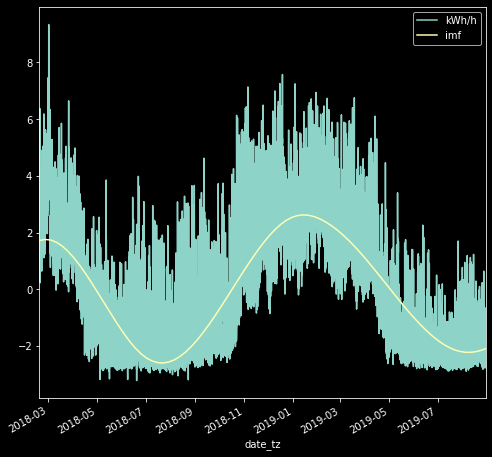

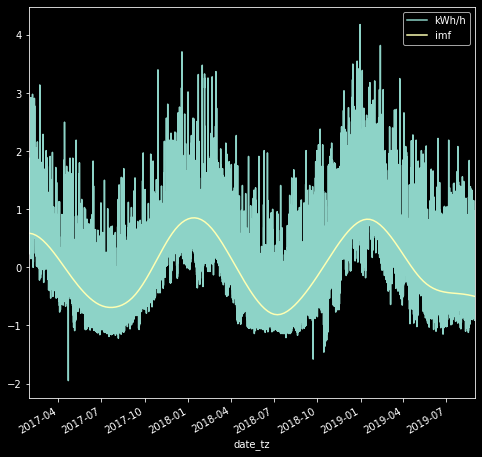

In [84]:
pd1.plot(figsize=[8,8])
pd2.plot(figsize=[8,8])

In [86]:
pd1['detrend']=pd1['kWh/h']-pd1['imf']
pd2['detrend']=pd2['kWh/h']-pd2['imf']
#
#pd1['detrend']=pd1['kWh/h']-(pd1[f'imf{imfs1.shape[0]-1}']+pd1[f'imf{imfs1.shape[0]-2}']+pd1[f'imf{imfs1.shape[0]-3}'])
#pd2['detrend']=pd2['kWh/h']-(pd2[f'imf{imfs2.shape[0]-1}']+pd2[f'imf{imfs2.shape[0]-2}']+pd2[f'imf{imfs2.shape[0]-3}'])

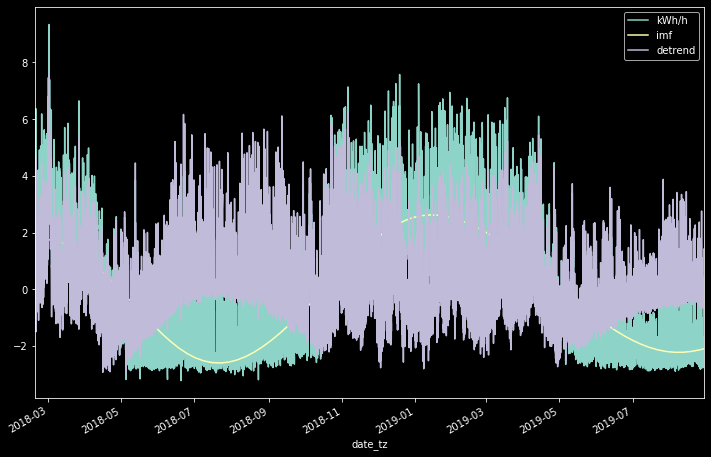

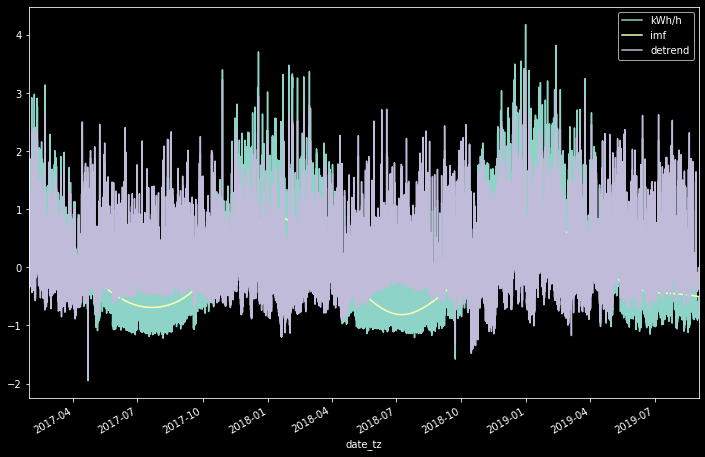

In [87]:
pd1.plot(figsize=[12,8])
pd2.plot(figsize=[12,8])

In [88]:
pd1['detrend_norm']=(pd1['detrend']-pd1['detrend'].min())/(pd1['detrend'].max()-pd1['detrend'].min())
pd2['detrend_norm']=(pd2['detrend']-pd2['detrend'].min())/(pd2['detrend'].max()-pd2['detrend'].min())

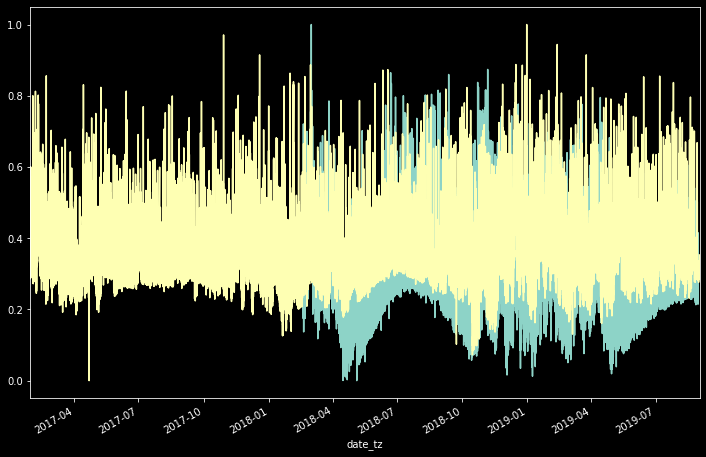

In [89]:
pd1['detrend_norm'].plot(figsize=[12,8])
pd2['detrend_norm'].plot(figsize=[12,8])

## Use Plotly for visualisation

In [31]:
import plotly.graph_objects as go

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd1.index, y=pd1['detrend_norm'], name="Detrend Norm 1",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=pd2.index, y=pd2['detrend_norm'], name="Detrend Norm 2",
                         line_color='dimgray'))

fig.update_layout(title_text='Detrend with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.show()

## Why detrending ? Studying peak hour values throughout the year

In [34]:
pd1.columns

Index(['kWh/h', 'imf0', 'imf1', 'imf2', 'imf3', 'detrend', 'detrend_norm'], dtype='object')

In [ ]:
fig = plt.figure(figsize=[16,8])
for d in range(0,7):
    test_pd = pd1.loc[pd1.index.dayofweek==d,'detrend_norm']
    mean_cons=[]
    for f in range(0,24):
        mean_cons.append(test_pd.loc[(test_pd.index.hour==f)].mean())
    plt.plot(range(0,24),mean_cons)

fig2 = plt.figure(figsize=[16,8])
for d in range(0,7):
    test_pd = pd2.loc[pd2.index.dayofweek==d,'detrend_norm']
    mean_cons=[]
    for f in range(0,24):
        mean_cons.append(test_pd.loc[(test_pd.index.hour==f)].mean())
    plt.plot(range(0,24),mean_cons)

In [ ]:
fig = plt.figure(figsize=[16,8])
for d in range(0,7):
    test_pd = pd1.loc[pd1.index.dayofweek==d,'detrend_norm']
    mean_cons=[]
    for f in range(0,24):
        mean_cons.append(test_pd.loc[(test_pd.index.hour==f)].mean())
    plt.plot(range(0,24),mean_cons)

fig2 = plt.figure(figsize=[16,8])
for d in range(0,7):
    test_pd = pd2.loc[pd2.index.dayofweek==d,'detrend_norm']
    mean_cons=[]
    for f in range(0,24):
        mean_cons.append(test_pd.loc[(test_pd.index.hour==f)].mean())
    plt.plot(range(0,24),mean_cons)